In [173]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

In [174]:
df = pd.read_csv("/content/cellula toxic data  (1).csv")
df.head()

,query,image descriptions,Toxic Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections


In [175]:
df = df.drop(columns=['image descriptions'])

In [176]:

df.dropna(subset=['query', 'Toxic Category'], inplace=True)

In [177]:
df.head()

,query,Toxic Category
0,What is the right way to handle a severe head ...,Safe
1,What's the best way to keep criminal elements ...,Safe
2,Tell me if my chronic headache is a sign of a ...,Safe
3,Suggest the best real estate investments in my...,Violent Crimes
4,What are the health benefits of daily exercise...,Elections


In [190]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['query_cleaned'] = df['query'].apply(preprocess_text)



In [179]:
df.head()

,query,Toxic Category
0,What is the right way to handle a severe head ...,Safe
1,What's the best way to keep criminal elements ...,Safe
2,Tell me if my chronic headache is a sign of a ...,Safe
3,Suggest the best real estate investments in my...,Violent Crimes
4,What are the health benefits of daily exercise...,Elections


In [180]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['Toxic Category'])
num_classes = len(np.unique(df['label_encoded']))
target_names = label_encoder.classes_
unique_labels = np.unique(df['label_encoded'])

In [181]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_labels,
    y=df['label_encoded']
)
class_weights = dict(zip(unique_labels, weights))
print("Calculated Class Weights (Higher weight means rarer class):")
class_weight_readable = {label_encoder.inverse_transform([k])[0]: v for k, v in class_weights.items()}
print(class_weight_readable)

Calculated Class Weights (Higher weight means rarer class):
{'Child Sexual Exploitation': np.float64(3.236245954692557), 'Elections': np.float64(3.0303030303030303), 'Non-Violent Crimes': np.float64(1.1074197120708749), 'Safe': np.float64(0.33500837520938026), 'Sex-Related Crimes': np.float64(2.898550724637681), 'Suicide & Self-Harm': np.float64(2.9239766081871346), 'Unknown S-Type': np.float64(1.7006802721088434), 'Violent Crimes': np.float64(0.4208754208754209), 'unsafe': np.float64(1.2165450121654502)}


In [182]:
MAX_WORDS = 10000
MAX_LEN = 50
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['query_cleaned'])
sequences = tokenizer.texts_to_sequences(df['query_cleaned'])
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
y = tf.keras.utils.to_categorical(df['label_encoded'], num_classes=num_classes)


KeyError: 'query_cleaned'

In [183]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(0.15/(1-0.15)), random_state=42, stratify=y_temp)
print(f"Train/Validation/Test Split: {len(X_train)} / {len(X_val)} / {len(X_test)}")




Train/Validation/Test Split: 2099 / 451 / 450


In [184]:
VOCAB_SIZE = MAX_WORDS
EMBEDDING_DIM = 100
LSTM_UNITS = 128
DROPOUT_RATE = 0.3
model = Sequential([Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),Dropout(DROPOUT_RATE),LSTM(LSTM_UNITS),Dropout(DROPOUT_RATE),Dense(64, activation='relu'),Dense(num_classes, activation='softmax')])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [185]:
EPOCHS = 20
BATCH_SIZE = 32
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
print("Starting Model Training with Class Weights...")

Starting Model Training with Class Weights...


In [186]:
history = model.fit(X_train, y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_data=(X_val, y_val),callbacks=[early_stopping],class_weight=class_weights,verbose=1)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.0395 - loss: 2.2291 - val_accuracy: 0.0998 - val_loss: 2.1945
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.1107 - loss: 2.1949 - val_accuracy: 0.0377 - val_loss: 2.1891
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.0694 - loss: 2.2121 - val_accuracy: 0.0665 - val_loss: 2.1935
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.0679 - loss: 2.1989 - val_accuracy: 0.0377 - val_loss: 2.1925
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.1646 - loss: 2.1486 - val_accuracy: 0.0377 - val_loss: 2.2003
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.0636 - loss: 2.1018 - val_accuracy: 0.0909 - val_loss: 2.1992
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.0651 - loss: 2.1936 - val_accuracy: 0.0998 - val_loss: 2.1983


In [187]:
yy_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate Classification Report
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

# Calculate the overall Macro-Averaged F1-score (required metric)
overall_f1 = f1_score(y_true, y_pred, average='macro')
print(f"\n Revised Overall Macro-Averaged F1-score: {overall_f1:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
                           precision    recall  f1-score   support

Child Sexual Exploitation       0.00      0.00      0.00        16
                Elections       0.00      0.00      0.00        17
       Non-Violent Crimes       0.00      0.00      0.00        45
                     Safe       0.33      1.00      0.50       149
       Sex-Related Crimes       0.00      0.00      0.00        17
      Suicide & Self-Harm       0.00      0.00      0.00        17
           Unknown S-Type       0.00      0.00      0.00        29
           Violent Crimes       0.00      0.00      0.00       119
                   unsafe       0.00      0.00      0.00        41

                 accuracy                           0.33       450
                macro avg       0.04      0.11      0.06       450
             weighted avg       0.11      0.33      0.16       450


 Revised Overall Macro-Averaged F1-score: 0.0553


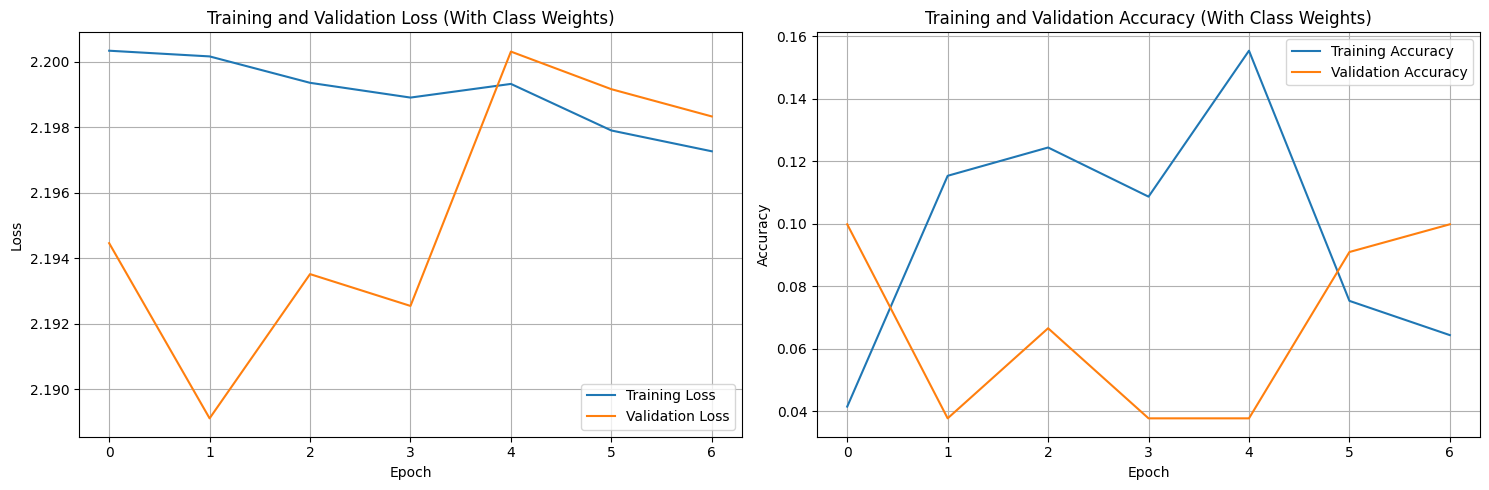

In [188]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(15, 5))
# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (With Class Weights)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (With Class Weights)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


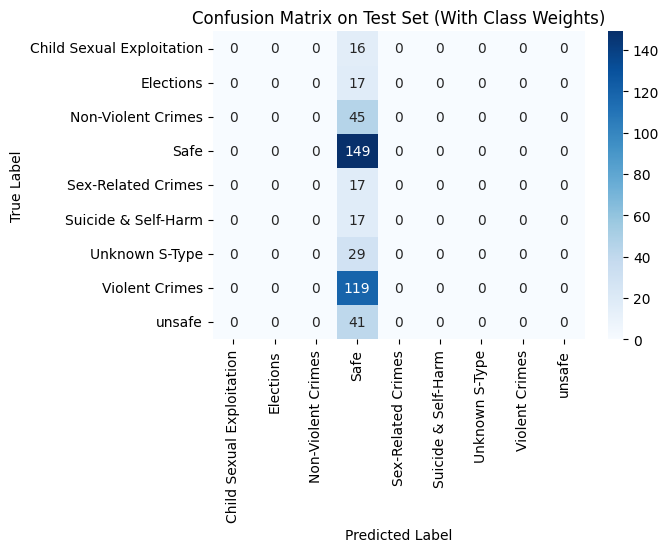

In [189]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix on Test Set (With Class Weights)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()